In [1]:
import pandas as pd
import numpy as np ,numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import random
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier

# EDA Rendements

In [2]:
url = "C:/Users/louis/Documents/Projet Finance Quantitative/"

In [3]:
database = pd.read_csv(url + "database.csv")
database["Date"] = pd.to_datetime(database["Date"])
num = [c for c, d in zip (database.columns,database.dtypes) if d==np.float]
db_rendements = pd.read_csv("db_rendements.csv")
fusion = pd.read_csv("Start_indicateurs.csv")

In [4]:
db_rendements[db_rendements["Titres"].isin(["DUKE ENERGY CORP","WEC ENERGY GROUP INC","DTE ENERGY COMPANY"])]

,Date,Titres,Return,lag1,lag2,lag3,lag4
17,2010-01-31,DUKE ENERGY CORP,-3.951191,NaN,NaN,NaN,NaN
34,2010-01-31,DTE ENERGY COMPANY,-3.555861,NaN,NaN,NaN,NaN
42,2010-01-31,WEC ENERGY GROUP INC,-1.786073,NaN,NaN,NaN,NaN
65,2010-02-28,DUKE ENERGY CORP,0.374613,-3.951191,NaN,NaN,NaN
82,2010-02-28,DTE ENERGY COMPANY,3.282588,-3.555861,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5811,2019-10-31,DTE ENERGY COMPANY,-4.241877,3.299655,2.006136,-0.602127,2.664294
5819,2019-10-31,WEC ENERGY GROUP INC,-0.736067,-0.699593,12.801470,2.506897,3.500931
5844,2019-11-30,DUKE ENERGY CORP,-5.459216,-1.669101,3.364244,8.073827,-1.722575
5861,2019-11-30,DTE ENERGY COMPANY,-1.869306,-4.241877,3.299655,2.006136,-0.602127


In [5]:
database.head()

,Date,HESS CORP,NEWMONT GOLDCORP CORP,INTEL CORP,INTL FLAVORS & FRAGRANCES,MOSAIC CO/THE,EXELON CORP,KIMBERLY-CLARK CORP,JOHNSON & JOHNSON,BAXTER INTERNATIONAL INC,...,INTL BUSINESS MACHINES CORP,WELLTOWER INC,INGERSOLL-RAND PLC,BAKER HUGHES CO,WEC ENERGY GROUP INC,OCCIDENTAL PETROLEUM CORP,WILLIAMS COS INC,UNION PACIFIC CORP,WASTE MANAGEMENT INC,CARNIVAL CORP
0,2010-01-31,-4.479339,-9.406045,-4.901961,-3.330092,-10.413530,-6.650297,-6.780725,-2.406459,-1.857532,...,-6.501146,-2.978339,-9.177392,12.218770,-1.786073,-3.700062,-1.138520,-5.320814,-5.205561,5.175134
1,2010-02-28,1.747707,14.979000,6.671663,5.883832,9.216614,-3.945733,2.273110,0.992332,-1.146032,...,4.366228,0.168924,-1.474259,5.830389,-0.212952,1.927495,3.358925,11.804920,3.026521,8.208021
2,2010-03-31,6.552083,3.553801,8.572821,13.825790,4.076040,1.177829,4.661590,3.492064,2.732195,...,0.857188,6.775259,9.276089,-2.253756,2.023539,6.302256,7.761559,8.802137,5.254409,8.120133
3,2010-04-30,1.598721,10.111920,2.467474,5.076568,-15.846630,-0.502169,-2.576336,-1.380368,-18.865980,...,0.584795,-0.663277,6.051047,6.233988,6.274034,4.873433,2.207792,3.219645,0.726111,7.253087
4,2010-05-31,-16.286390,-4.029957,-5.550986,-11.159910,-9.626484,-10.344880,-0.914137,-8.501832,-10.567560,...,-2.389900,-2.517121,0.892374,-23.101220,-5.965246,-6.936612,-16.349000,-5.146491,-5.353629,-12.882820


### Corrélations 

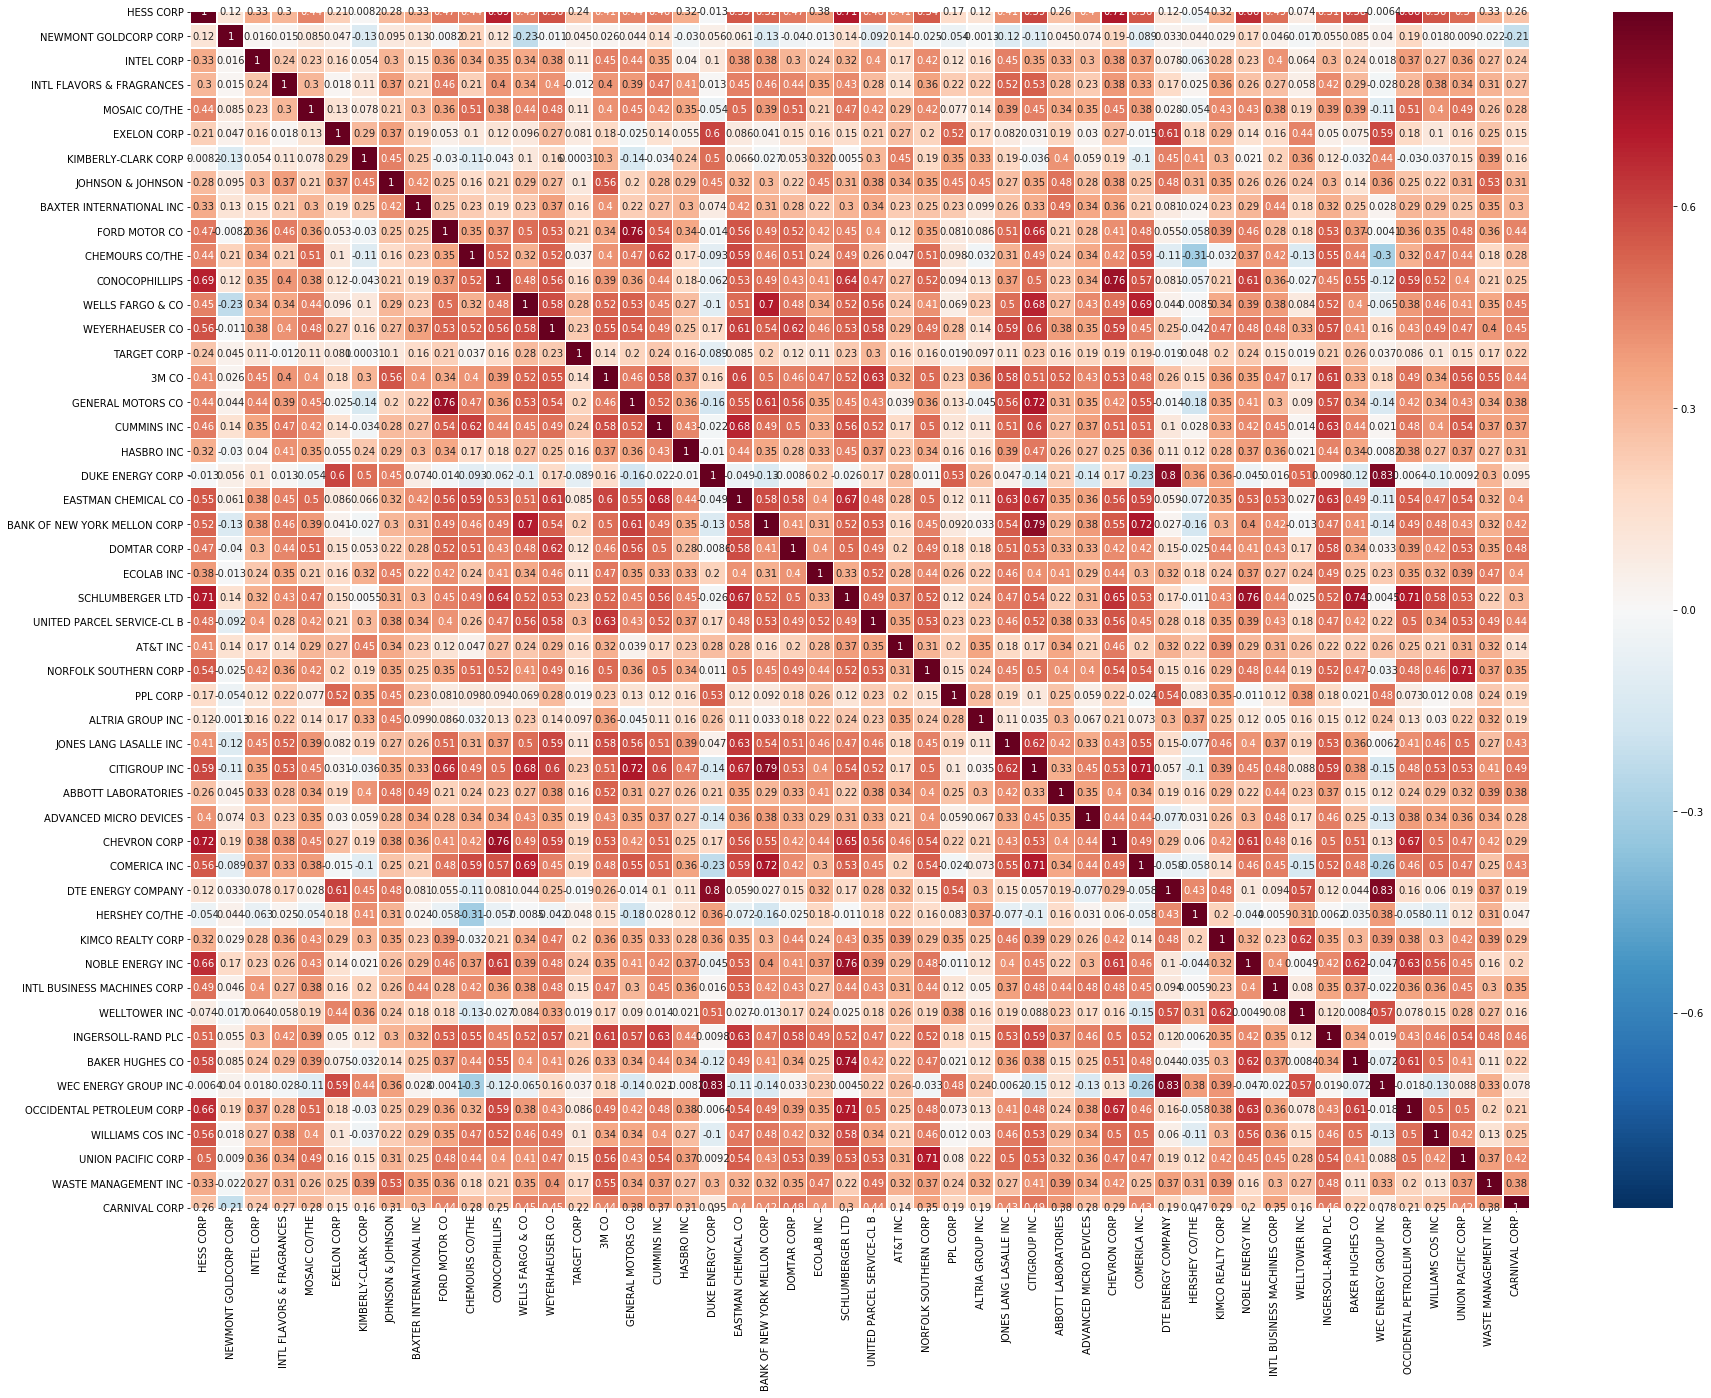

In [8]:
pearsoncorr = database[num].corr() 
fig, ax = plt.subplots(figsize=(30,22)) 
ax = sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels = pearsoncorr.columns, cmap='RdBu_r', annot=True,linewidth = 0.5,vmin=-0.89, vmax=0.89) 

In [9]:
corr = pearsoncorr.abs()
corr = corr.unstack()
corr = corr.sort_values(kind="quicksort")
corr = corr[(corr>0.80)&(corr<0.9999)]

#Titres corrélées à plus de 0.8
corr

DUKE ENERGY CORP      DTE ENERGY COMPANY      0.801879
DTE ENERGY COMPANY    DUKE ENERGY CORP        0.801879
                      WEC ENERGY GROUP INC    0.826089
WEC ENERGY GROUP INC  DTE ENERGY COMPANY      0.826089
                      DUKE ENERGY CORP        0.827648
DUKE ENERGY CORP      WEC ENERGY GROUP INC    0.827648
dtype: float64

Titres fortement corrélés qu'on décide d'enlever : 
FORD MOTOR CO / NOBLE ENERGY INC / CHEVRON CORP / BANK OF NEW YORK MELLON CORP / DTE ENERGY COMPANY / WEC ENERGY GROUP INC

On peut remarquer que les titres fortement corrélés sont des titres appartenant souvent au même secteur d'activité. \
Exemple : 
        Automobile : GM VS Ford\
        Energie : Noble energy VS Schlumberger\
        Bancaire :  Citi VS Bank Of New York\
        etc ...

In [10]:
db_rendements

,Date,Titres,Return,lag1,lag2,lag3,lag4
0,2010-01-31,HESS CORP,-4.479339,NaN,NaN,NaN,NaN
1,2010-01-31,NEWMONT GOLDCORP CORP,-9.406045,NaN,NaN,NaN,NaN
2,2010-01-31,INTEL CORP,-4.901961,NaN,NaN,NaN,NaN
3,2010-01-31,INTL FLAVORS & FRAGRANCES,-3.330092,NaN,NaN,NaN,NaN
4,2010-01-31,MOSAIC CO/THE,-10.413530,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5870,2019-11-30,OCCIDENTAL PETROLEUM CORP,-4.765432,-8.927367,4.073635,-15.342680,2.147971
5871,2019-11-30,WILLIAMS COS INC,1.837741,-7.273483,3.544075,-4.220779,-12.125540
5872,2019-11-30,UNION PACIFIC CORP,6.946350,2.148413,0.012349,-9.457417,6.410029
5873,2019-11-30,WASTE MANAGEMENT INC,0.623830,-2.426087,-3.230081,2.008547,1.412846


### Variation des rendements

(-25, 25)

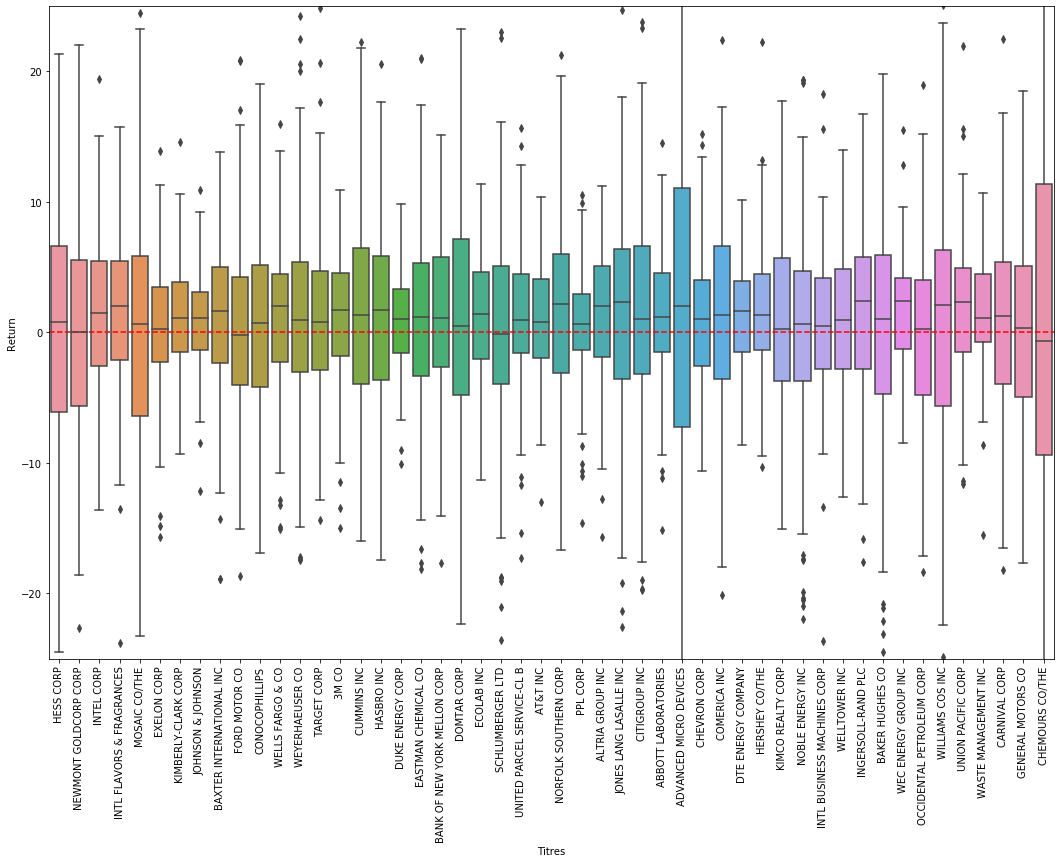

In [11]:
fig, ax = plt.subplots(figsize=(18,12))
sns.boxplot(x='Titres', y='Return', data=db_rendements)
#sns.swarmplot(x='Titres', y='Return', data=db, color="grey")
plt.axhline(0, ls='--',color="red")
plt.xticks(rotation=90)
plt.ylim(-25,25)

# EDA Indicateurs

In [12]:
fusion[["Tickers","Date_active"]]# La date à laquelle chacun de ces titres rentrera dans notre portefeuille.

,Tickers,Date_active
0,CC US Equity,2016-04-30
1,BKR US Equity,2018-10-31
2,GM US Equity,2014-01-31
3,CMI US Equity,2010-07-31
4,INTC US Equity,2010-10-31
5,OXY US Equity,2011-10-31
6,WY US Equity,2010-10-31
7,BK US Equity,2010-07-31
8,CI US Equity,2011-01-31
9,CMA US Equity,2010-07-31


In [26]:
def corr_feat(company):
    table = pd.read_csv("db_train.csv")
    del table["lag1"]
    del table["lag2"]
    del table["lag3"]
    del table["lag4"]
    temp = table#[table["Titres"] == company]
    pearsoncorr = temp[[c for c, d in zip (temp.columns,temp.dtypes) if d==np.float]].corr() 
    fig, ax = plt.subplots(figsize=(30,22)) 
    ax = sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels = pearsoncorr.columns, cmap='RdBu_r', annot=True,linewidth = 0.5,vmin=-0.89, vmax=0.89) 
    return ax

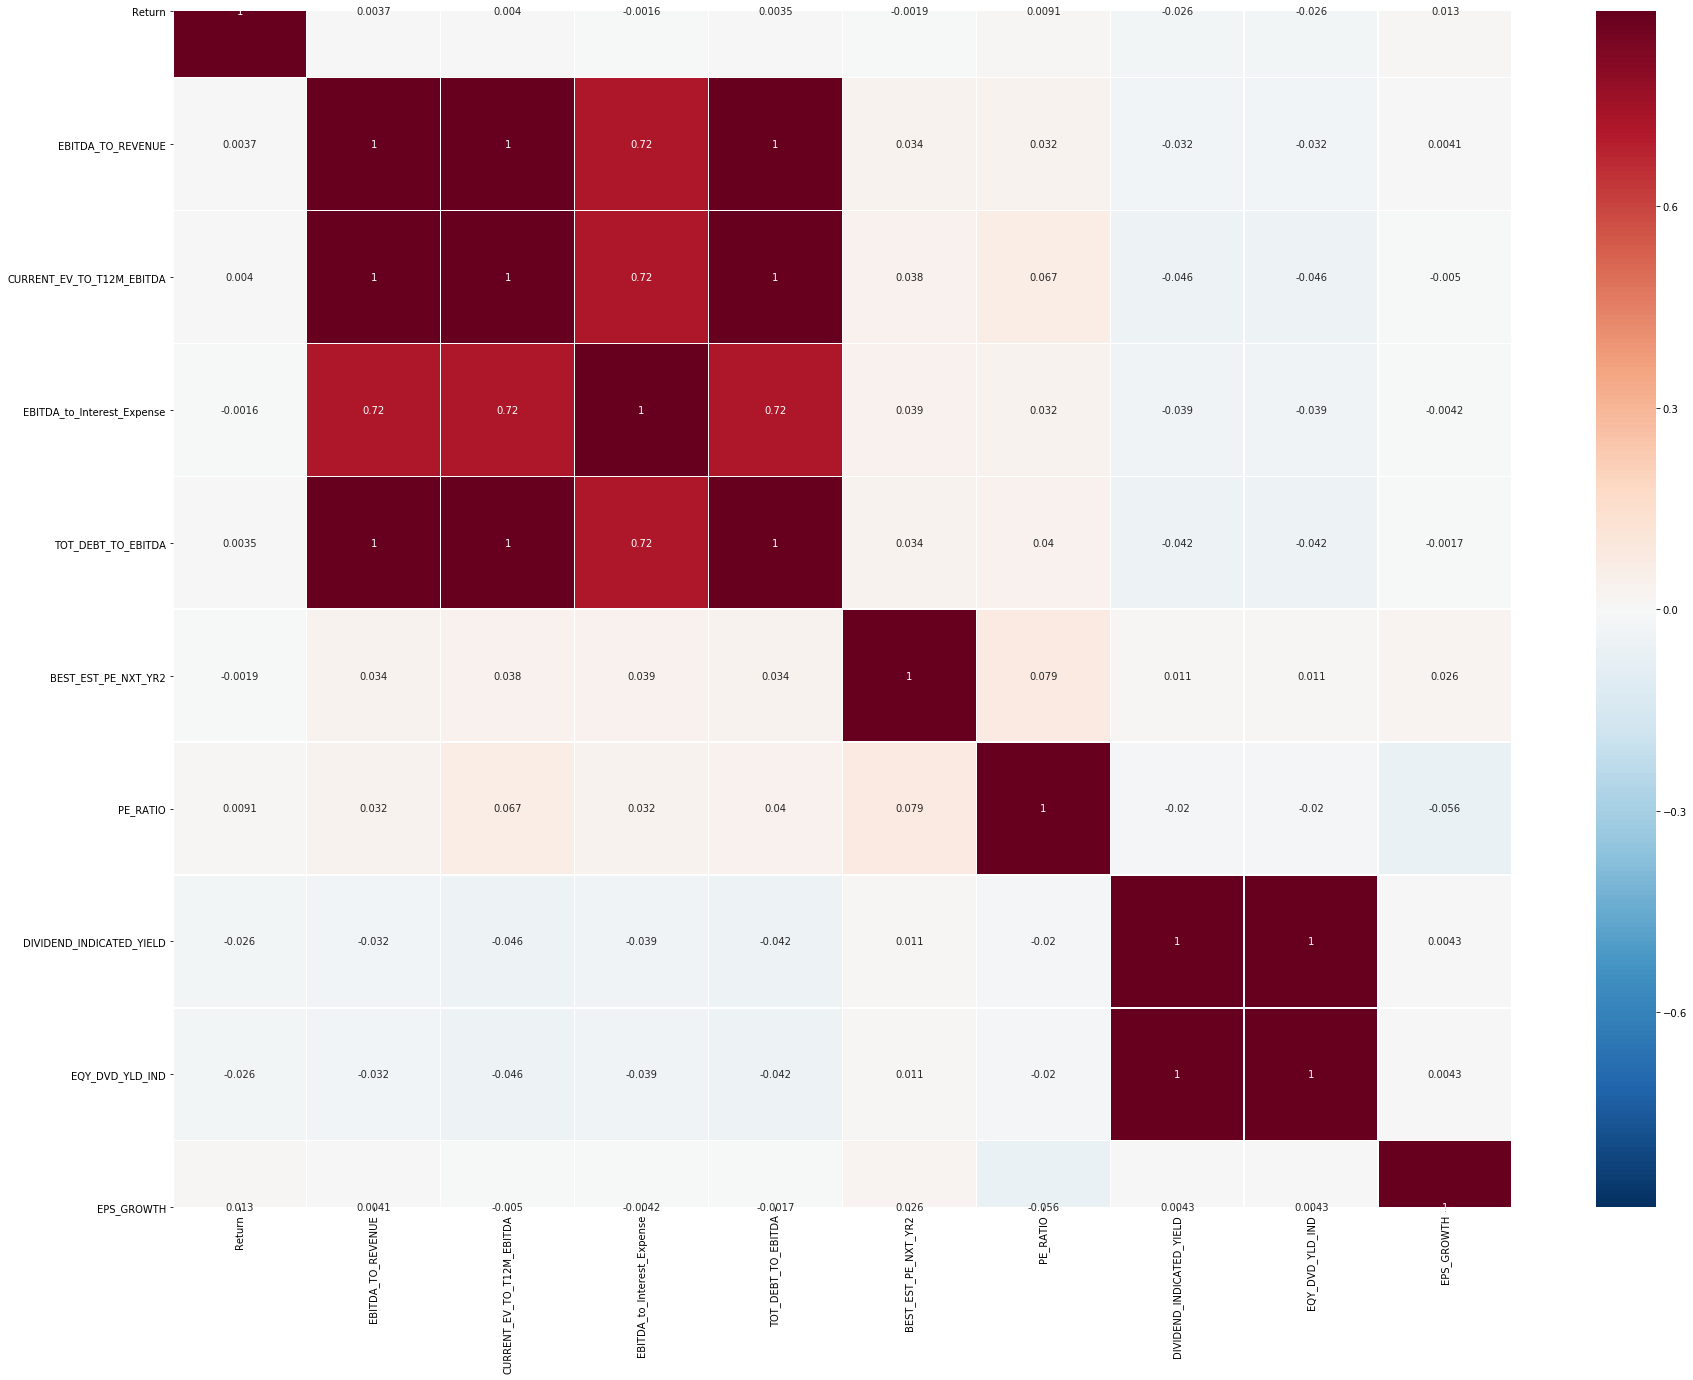

In [27]:
corr_feat("a")

In [28]:
pd.set_option("display.max_rows",500)
pd.read_csv("database.csv").set_index("Date").T

Date,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,...,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30
HESS CORP,-4.479339,1.747707,6.552083,1.598721,-16.286390,-5.199633,6.456099,-6.232506,17.862510,6.613667,...,7.129630,4.560930,6.458575,-12.882100,14.299320,1.997798,-2.914867,-3.543821,8.713624,-5.566540
NEWMONT GOLDCORP CORP,-9.406045,14.979000,3.553801,10.111920,-4.029957,14.919660,-9.459022,9.695886,2.682291,-3.104601,...,0.029317,5.278753,-10.971060,6.535738,16.730600,-5.068885,9.227820,-4.594867,4.773207,-3.347596
INTEL CORP,-4.901961,6.671663,8.572821,2.467474,-5.550986,-9.197012,5.912596,-13.596050,8.689499,4.427083,...,13.103390,1.397281,-4.953445,-13.184080,8.696639,5.598496,-5.582555,8.690149,9.703086,3.250417
INTL FLAVORS & FRAGRANCES,-3.330092,5.883832,13.825790,5.076568,-11.159910,-4.156645,6.977840,0.683120,6.780023,3.380049,...,-10.071940,1.603140,6.988120,-1.720009,7.677665,-0.758150,-23.779430,12.488130,-0.554242,15.752810
MOSAIC CO/THE,-10.413530,9.216614,4.076040,-15.846630,-9.626484,-15.572880,22.242180,23.228160,0.170474,24.506470,...,-3.128872,-12.589200,-4.393995,-17.770970,16.843260,0.639233,-26.994840,11.780550,-3.024390,-4.175050
EXELON CORP,-6.650297,-3.945733,1.177829,-0.502169,-10.344880,-1.632124,10.165920,-1.414644,4.567780,-4.133396,...,2.503795,3.169376,1.635747,-4.934422,-0.291181,-6.007509,5.737142,2.221752,-5.837301,-1.603359
KIMBERLY-CLARK CORP,-6.780725,2.273110,4.661590,-2.576336,-0.914137,0.963629,5.756226,0.436681,2.018187,-2.628747,...,4.893158,6.999896,3.615819,-0.381679,5.018130,1.778211,4.025064,1.409523,-6.455473,2.603853
JOHNSON & JOHNSON,-2.406459,0.992332,3.492064,-1.380368,-8.501832,1.303602,-1.642398,-0.921738,8.663627,2.872821,...,3.353552,2.305328,1.008656,-6.482070,6.199009,-6.504882,-0.695621,0.794640,2.055959,4.848642
BAXTER INTERNATIONAL INC,-1.857532,-1.146032,2.732195,-18.865980,-10.567560,-3.084078,7.701772,-2.787297,12.883640,6.749109,...,3.352186,8.805032,-6.161604,-3.748362,11.838860,2.527472,5.003134,-0.545765,-12.312790,6.870926
FORD MOTOR CO,8.400000,8.302583,7.069847,3.579952,-9.907834,-14.066500,26.686510,-11.628820,8.462561,15.441180,...,-0.340909,0.114025,20.899770,-8.899522,7.457983,-5.448048,-3.777544,-0.109051,-4.664945,5.471478


In [29]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
table = pd.read_csv("database.csv")
table=table.set_index("Date").T.dropna()
table=table.dropna()

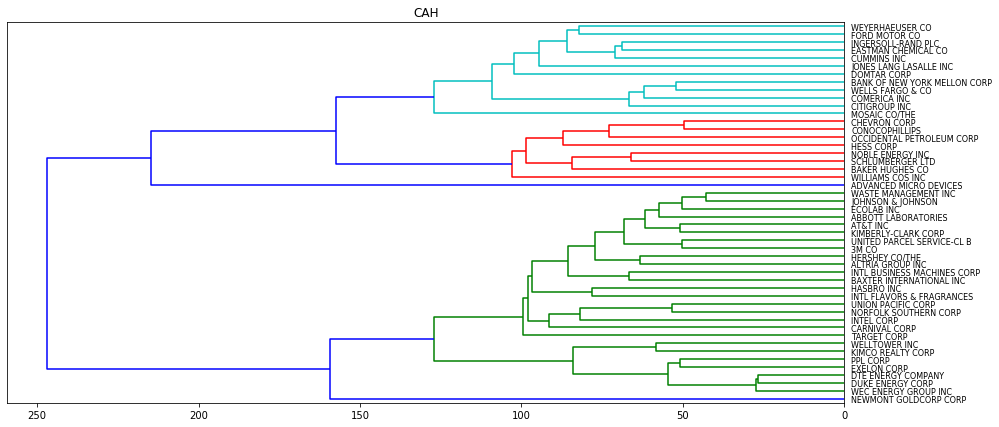

[3 2 1 1 4 1 1 1 1 4 3 4 4 1 1 4 1 1 4 4 4 1 3 1 1 1 1 1 4 4 1 5 3 4 1 1 1
 3 1 1 4 3 1 3 3 1 1 1]
                              0
1    UNITED PARCEL SERVICE-CL B
1            UNION PACIFIC CORP
1          WEC ENERGY GROUP INC
1                 WELLTOWER INC
1   INTL BUSINESS MACHINES CORP
1             KIMCO REALTY CORP
1                HERSHEY CO/THE
1            DTE ENERGY COMPANY
1           ABBOTT LABORATORIES
1              ALTRIA GROUP INC
1                      PPL CORP
1         NORFOLK SOUTHERN CORP
1                      AT&T INC
1          WASTE MANAGEMENT INC
1                    ECOLAB INC
1              DUKE ENERGY CORP
1                 CARNIVAL CORP
1                         3M CO
1                    INTEL CORP
1                   TARGET CORP
1     INTL FLAVORS & FRAGRANCES
1                   EXELON CORP
1           KIMBERLY-CLARK CORP
1             JOHNSON & JOHNSON
1      BAXTER INTERNATIONAL INC
1                    HASBRO INC
2         NEWMONT GOLDCORP CORP
3    

In [30]:
Z = linkage(table,method='ward',metric='euclidean')
fig = plt.figure(figsize=(15,7))
plt.title("CAH")
dendrogram(Z,labels=table.index,orientation='left',color_threshold=150)#150
plt.show()
groupes_cah = fcluster(Z,t=150,criterion='distance')#150
print(groupes_cah)
idg= np.argsort(groupes_cah)
print(pd.DataFrame(table.index[idg],groupes_cah[idg]))

[0.12366916 0.10463215 0.04712025 0.0506611  0.0865677  0.07177921
 0.05575982 0.08558262 0.07621413]


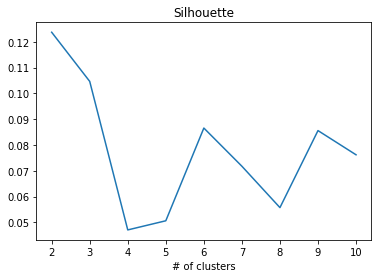

Nombre de Kmeans optimal 3
                              0
0           ABBOTT LABORATORIES
0              DUKE ENERGY CORP
0             KIMCO REALTY CORP
0                    ECOLAB INC
0              ALTRIA GROUP INC
0                   TARGET CORP
0                 WELLTOWER INC
0          WASTE MANAGEMENT INC
0                HERSHEY CO/THE
0          WEC ENERGY GROUP INC
0             JOHNSON & JOHNSON
0           KIMBERLY-CLARK CORP
0                   EXELON CORP
0                      AT&T INC
0                      PPL CORP
0         NEWMONT GOLDCORP CORP
0      BAXTER INTERNATIONAL INC
0            DTE ENERGY COMPANY
1        ADVANCED MICRO DEVICES
2                  CHEVRON CORP
2                     HESS CORP
2              NOBLE ENERGY INC
2            INGERSOLL-RAND PLC
2               BAKER HUGHES CO
2     OCCIDENTAL PETROLEUM CORP
2              WILLIAMS COS INC
2            UNION PACIFIC CORP
2                  COMERICA INC
2   INTL BUSINESS MACHINES CORP
2    UNITED P

col_0,0,1,2
row_0,,,
1,17,0,9
2,1,0,0
3,0,0,8
4,0,0,12
5,0,1,0


In [42]:
from sklearn import metrics
from sklearn import cluster 
res= np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+3)
    km.fit(table)
    res[k] = metrics.silhouette_score(table,km.labels_)
print(res)
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

print("Nombre de Kmeans optimal {}" .format(res.argmax()+3))
kmeans= cluster.KMeans(n_clusters=res.argmax()+3)
kmeans.fit(table)
idk= np.argsort(kmeans.labels_)
print(pd.DataFrame(table.index[idk],kmeans.labels_[idk]))
print(kmeans.transform(table))
pd.crosstab(groupes_cah,kmeans.labels_)